<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-and-basic-functions" data-toc-modified-id="Libraries-and-basic-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries and basic functions</a></span></li><li><span><a href="#plotting-functions" data-toc-modified-id="plotting-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>plotting functions</a></span><ul class="toc-item"><li><span><a href="#Reference" data-toc-modified-id="Reference-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reference</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Workflow" data-toc-modified-id="Workflow-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Workflow</a></span><ul class="toc-item"><li><span><a href="#load-dataset-(Example:-0424_mds/)" data-toc-modified-id="load-dataset-(Example:-0424_mds/)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>load dataset (Example: 0424_mds/)</a></span></li><li><span><a href="#Single-frame-with-3D-bbox" data-toc-modified-id="Single-frame-with-3D-bbox-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Single frame with 3D bbox</a></span></li><li><span><a href="#Single-frame-in-2D" data-toc-modified-id="Single-frame-in-2D-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Single frame in 2D</a></span></li><li><span><a href="#Multiple-frames-in-2D" data-toc-modified-id="Multiple-frames-in-2D-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Multiple frames in 2D</a></span><ul class="toc-item"><li><span><a href="#aggregate-multiply-frames" data-toc-modified-id="aggregate-multiply-frames-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>aggregate multiply frames</a></span><ul class="toc-item"><li><span><a href="#Example:-Frame-100,-1500,-2372" data-toc-modified-id="Example:-Frame-100,-1500,-2372-3.4.1.1"><span class="toc-item-num">3.4.1.1&nbsp;&nbsp;</span>Example: Frame 100, 1500, 2372</a></span></li><li><span><a href="#Example:-Frame-1500" data-toc-modified-id="Example:-Frame-1500-3.4.1.2"><span class="toc-item-num">3.4.1.2&nbsp;&nbsp;</span>Example: Frame 1500</a></span></li></ul></li></ul></li><li><span><a href="#Extract-tracking-results" data-toc-modified-id="Extract-tracking-results-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Extract tracking results</a></span></li><li><span><a href="#multiple-frames-with-trarklets" data-toc-modified-id="multiple-frames-with-trarklets-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>multiple frames with trarklets</a></span></li></ul></li></ul></div>

# Viz points in 2d

## Libraries and basic functions

In [1]:
import os
import sys
#SERVER
sys.path.append('/usr/lib/python3/dist-packages')
sys.path.append('/home/jupyter-dominik/.conda/envs/ros_env/lib/python3.9/site-packages')
#SERVER
from pathlib import Path
import tqdm
import cv2

import pandas as pd
import numpy as np

import matplotlib as mpl
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()

from mpl_toolkits.mplot3d import Axes3D

from qolo.core.crowdbot_data import CrowdBotDatabase, CrowdBotData
from qolo.utils.viz_util import (
    boxes3d_to_corners3d,
    filter_pointcloud_distance,
    filter_detection_tracking_res,
)

sys.path.append('/home/jupyter-dominik/LiDAR_ground_removal')
from module.ground_removal import Processor

In [2]:
import inspect
 
# derived from https://stackoverflow.com/a/18425523/7961693
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def mod_retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def plen(array):
    print("Length of {}: {}".format(mod_retrieve_name(array)[0], len(array)))


def pshape(array):
    print("Shape of {}: {}".format(mod_retrieve_name(array)[0], array.shape))


def pminmax(array):
    print("[Min, Max] of {}: [{}, {}]".format(mod_retrieve_name(array)[0], np.min(array), np.max(array)))
    
    
def ptype(obj):
    print("Type of {}: {}".format(mod_retrieve_name(obj)[0], type(obj)))
          
    
a = [5,2,3]
plen(a)

b = np.array(a).reshape(3,1)
pshape(b)

pminmax(a)

ptype(a)

Length of a: 3
Shape of b: (3, 1)
[Min, Max] of a: [2, 5]
Type of a: <class 'list'>


## plotting functions

### Reference

- https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb
- https://github.com/epfl-lasa/crowd_tracker_lidar3d/blob/master/jupyter_nbs/VisualValidation.ipynb

### Implementation

In [3]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}

gs_blue = (66.0 / 256, 133.0 / 256, 244.0 / 256)
gs_blue = np.array(gs_blue).reshape(1,3)
gs_red = (234.0 / 256, 68.0 / 256, 52.0 / 256)
gs_yellow = (251.0 / 256, 188.0 / 256, 4.0 / 256)
gs_green = (52.0 / 256, 168.0 / 256, 83.0 / 256)
gs_orange = (255.0 / 256, 109.0 / 256, 1.0 / 256)
gs_blue_light = (70.0 / 256, 189.0 / 256, 196.0 / 256)

default_axes_limits = [
    [-8, 8], # X axis range
    [-8, 8], # Y axis range
    [-3, 10]   # Z axis range
]

axes_str = ['X', 'Y', 'Z']

In [4]:
def get_limits(pc):
    x_max, x_min = np.max(pc[:, 0]), np.min(pc[:, 0])
    y_max, y_min = np.max(pc[:, 1]), np.min(pc[:, 1])
    z_max, z_min = np.max(pc[:, 2]), np.min(pc[:, 2])

    axes_limits = [
        [x_min, x_max],  # X axis range
        [y_min, y_max],  # Y axis range
        [z_min, z_max],  # Z axis range
    ]
    return axes_limits


def get_traj_limits(pose_array, offset=2.0):
    x_max, x_min = np.max(pose_array[:, 0])+offset, np.min(pose_array[:, 0])-offset
    y_max, y_min = np.max(pose_array[:, 1])+offset, np.min(pose_array[:, 1])-offset
    z_max, z_min = np.max(pose_array[:, 2])+0.2*offset, np.min(pose_array[:, 2])-0.2*offset

    axes_limits = [
        [x_min, x_max],  # X axis range
        [y_min, y_max],  # Y axis range
        [z_min, z_max],  # Z axis range
    ]
    return axes_limits


def update_limits(pc, axes_limits):
    flatten_ = np.array(axes_limits).flatten()

    x_max, x_min = np.max(pc[:, 0]), np.min(pc[:, 0])
    y_max, y_min = np.max(pc[:, 1]), np.min(pc[:, 1])
    z_max, z_min = np.max(pc[:, 2]), np.min(pc[:, 2])

    new_axes_limits = [
        [np.min([x_min, flatten_[0]]), np.max([x_max, flatten_[1]])],  # X axis range
        [np.min([y_min, flatten_[2]]), np.max([y_max, flatten_[3]])],  # Y axis range
        [np.min([z_min, flatten_[4]]), np.max([z_max, flatten_[5]])],  # Z axis range
    ]
    return new_axes_limits

In [5]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black', lw=1):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=lw)

In [6]:
def display_frame_all(
    pc,
    axes_limits=None,
    bbox=None,
    point_sz=0.5,
    points=0.8,
    plotting=False,
    filter_h=0.2,
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    # filter
    pc = filter_pointcloud_distance(pc, filter_dist, verbose)
    # downsample
    points_step = int(1. / points)
    point_idx = range(0, pc.shape[0], points_step)
    pc = pc[point_idx, :]
    
    # filter height to avoid too many ground points
    pc = pc[pc[:,2]>=filter_h]
    
    axes_limits = update_limits(pc, axes_limits)
    
    def draw_point_cloud(
        ax,
        axes=[0, 1, 2],
        bboxes=None,
        xlim3d=None,
        ylim3d=None,
        zlim3d=None,
        title="",
        equalax=False,
    ):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """

        if len(axes) == 3:
            ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=point_sz, c=gs_blue)
        elif len(axes) == 2:
            ax.scatter(pc[:, axes[0]], pc[:, axes[1]], s=point_sz, c=gs_blue)
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
            # ax.grid(False)
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d != None:
            ax.set_xlim3d(xlim3d)
        if ylim3d != None:
            ax.set_ylim3d(ylim3d)
        if zlim3d != None:
            ax.set_zlim3d(zlim3d)

        if bboxes is not None:
            bbox = filter_detection_tracking_res(bboxes, dist=filter_dist, verbose=verbose)
            # from detection
            if bbox.shape[1] == 7:
                bbox3d = boxes3d_to_corners3d(bbox, bottom_center=False)
                ids = np.zeros(bbox.shape[0])
            # from tracking
            elif bbox.shape[1] == 8:
                ids = bbox[:, -1]
                bbox = bbox[:, :-1]
                bbox3d = boxes3d_to_corners3d(bbox, bottom_center=False)
            for n in range(len(bbox3d)):
                b = bbox3d[n].T
                draw_box(ax, b, axes=axes, color='r')

        if equalax:
            ax.axis('equal')

    # Draw point cloud data as 3D plot
    fig3d = plt.figure(figsize=(15, 8))
    ax3d = fig3d.add_subplot(111, projection='3d')
    print(type(ax3d))
    draw_point_cloud(ax3d, bboxes=bbox, title='Pointcloud')
    if plotting:
        plt.show()

    # Draw point cloud data as plane projections
    fig_proj, ax_proj = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax_proj[0],
        axes=[0, 1],  # X and Y axes
        bboxes=bbox,
        title='Pointcloud in XY projection (Z = 0)',
        equalax=True,
    )
    draw_point_cloud(
        ax_proj[1],
        axes=[0, 2],  # X and Z axes
        bboxes=bbox,
        title='Pointcloud in XZ projection (Y = 0)',
        equalax=True,
    )
    draw_point_cloud(
        ax_proj[2],
        axes=[1, 2],  # Y and Z axes
        bboxes=bbox,
        title='Pointcloud in YZ projection (X = 0)',
        equalax=True,
    )
    if plotting:
        plt.show()
    return fig3d, fig_proj, ax3d, ax_proj

In [7]:
def display_frame(
    fig,
    pc=None,
    axes_limits=default_axes_limits,
    bbox=None,
    point_sz=0.5,
    points=0.8,
    proj='xy',
    plotting=False,
    filter_h=0.2
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """
    
    # filter
    pc = filter_pointcloud_distance(pc, filter_dist, verbose)
    # downsample
    points_step = int(1. / points)
    point_idx = range(0, pc.shape[0], points_step)
    pc = pc[point_idx, :]
    
    # filter height to avoid too many ground points
    pc = pc[pc[:,2]>=filter_h]
    
    axes_limits = update_limits(pc, axes_limits)

    def draw_point_cloud(
        ax, 
        axes=[0, 1, 2], 
        bboxes=None, 
        xlim3d=None, 
        ylim3d=None, 
        zlim3d=None, 
        title="", 
        equalax=False,
    ):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        
        
        if len(axes) == 3:
            ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=point_sz, c=gs_blue)
        elif len(axes) == 2:
            ax.scatter(pc[:, axes[0]], pc[:, axes[1]], s=point_sz, c=gs_blue)
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
            # ax.grid(False)
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d != None:
            ax.set_xlim3d(xlim3d)
        if ylim3d != None:
            ax.set_ylim3d(ylim3d)
        if zlim3d != None:
            ax.set_zlim3d(zlim3d)

        if bboxes is not None:
            bbox = filter_detection_tracking_res(bboxes, dist=filter_dist, verbose=verbose)
            # from detection
            if bbox.shape[1] == 7:
                bbox3d = boxes3d_to_corners3d(bbox, bottom_center=False)
                ids = np.zeros(bbox.shape[0])
            # from tracking
            elif bbox.shape[1] == 8:
                ids = bbox[:, -1]
                bbox = bbox[:, :-1]
                bbox3d = boxes3d_to_corners3d(bbox, bottom_center=False)
            for n in range(len(bbox3d)):
                b = bbox3d[n].T
                draw_box(ax, b, axes=axes, color='r')
        
        if equalax:
            ax.axis('equal')
    
    if proj == '3d':
        # Draw point cloud data as 3D plot
        # fig3d = plt.figure(figsize=(15, 8))
        #ax3d = fig3d.add_subplot(111, projection='3d')
        axes = fig.add_subplot(111, projection='3d')
        draw_point_cloud(
            axes, 
            bboxes=bbox,
            title='Pointcloud',
        )
    elif proj == 'xy':
        # Draw point cloud data as plane projections
        # fig_proj, ax_proj = plt.subplots(figsize=(15, 10))
        axes = fig.add_subplot(111)
        draw_point_cloud(
            axes,
            axes=[0, 1],  # X and Y axes
            bboxes=bbox,
            title='Pointcloud in XY projection (Z = 0)',
            equalax=True,
        )
    elif proj == 'all':
        # fig_proj, ax_proj = plt.subplots(3, 1, figsize=(15, 25))
        ax_proj1 = fig.add_subplot(311)   #top left
        ax_proj2 = fig.add_subplot(312)   #top right
        ax_proj3 = fig.add_subplot(313)   #bottom left
        draw_point_cloud(
            ax_proj1,
            axes=[0, 1],  # X and Y axes
            bboxes=bbox,
            title='Pointcloud in XY projection (Z = 0)',
            equalax=True,
        )
        draw_point_cloud(
            ax_proj2,
            axes=[0, 2],  # X and Z axes
            bboxes=bbox,
            title='Pointcloud in XZ projection (Y = 0)',
            equalax=True,
        )
        draw_point_cloud(
            ax_proj3,
            axes=[1, 2],  # Y and Z axes
            bboxes=bbox,
            title='Pointcloud in YZ projection (X = 0)',
            equalax=True,
        )
    if plotting:
        plt.show()

    return fig

## Workflow

In [8]:
filtering = True
filter_dist = 10
verbose = False
#LOCAL
#config_path = os.path.abspath(os.path.join(Path.cwd(), "..", "data", "data_path.yaml"))
#SERVER
config_path = '/scai_data/data01/daav/CrowdBot/config/data_path.yaml'

### load dataset (Example: 0424_mds/)

In [9]:
qolo_dataset = CrowdBotData(config=config_path)
print("rosbag database:", qolo_dataset.bagbase_dir)
print("output database:", qolo_dataset.outbase_dir)

rosbag database: /scai_data/data01/daav/CrowdBot/rosbags
output database: /scai_data/data01/daav/CrowdBot


In [10]:
example_class = '0424_mds_test'
example_seq = '2021-04-24-12-04-04'

In [11]:
cb_data = CrowdBotDatabase(example_class, config=config_path)

### Single frame with 3D bbox

In [12]:
seq_idx, fr_idx = 0, 0
seq = cb_data.seqs[seq_idx]

In [13]:
print(
    "({}/{}): {} with {} frames".format(
        0 + 1, cb_data.nr_seqs(), seq, cb_data.nr_frames(seq_idx)
    )
)

(1/6): 2021-04-24-12-04-04 with 2373 frames


In [14]:
lidar, dets, dets_conf, trks = cb_data[0, 100]

pc = lidar.T

pshape(pc)
pshape(dets)
pshape(dets_conf)
pshape(trks)

Shape of pc: (19764, 3)
Shape of dets: (100, 7)
Shape of dets_conf: (100,)
Shape of trks: (20, 8)


In [15]:
dets_conf[dets_conf > 0.7].shape

(12,)

In [16]:
np.histogram(pc[:,2]) # HEIGHT

(array([  12, 7683, 7384, 1856, 1255,  791,  514,  198,   55,   16]),
 array([-1.57667446, -0.77391376,  0.02884693,  0.83160763,  1.63436832,
         2.43712902,  3.23988972,  4.04265041,  4.84541111,  5.64817181,
         6.4509325 ]))

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


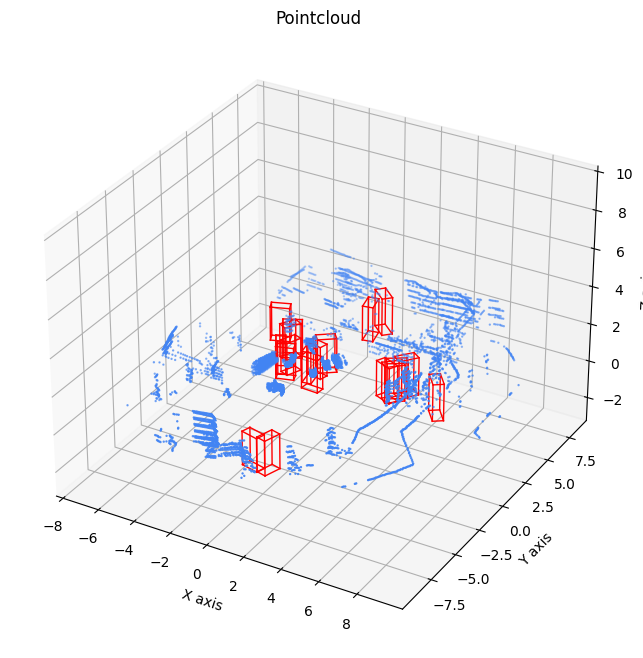

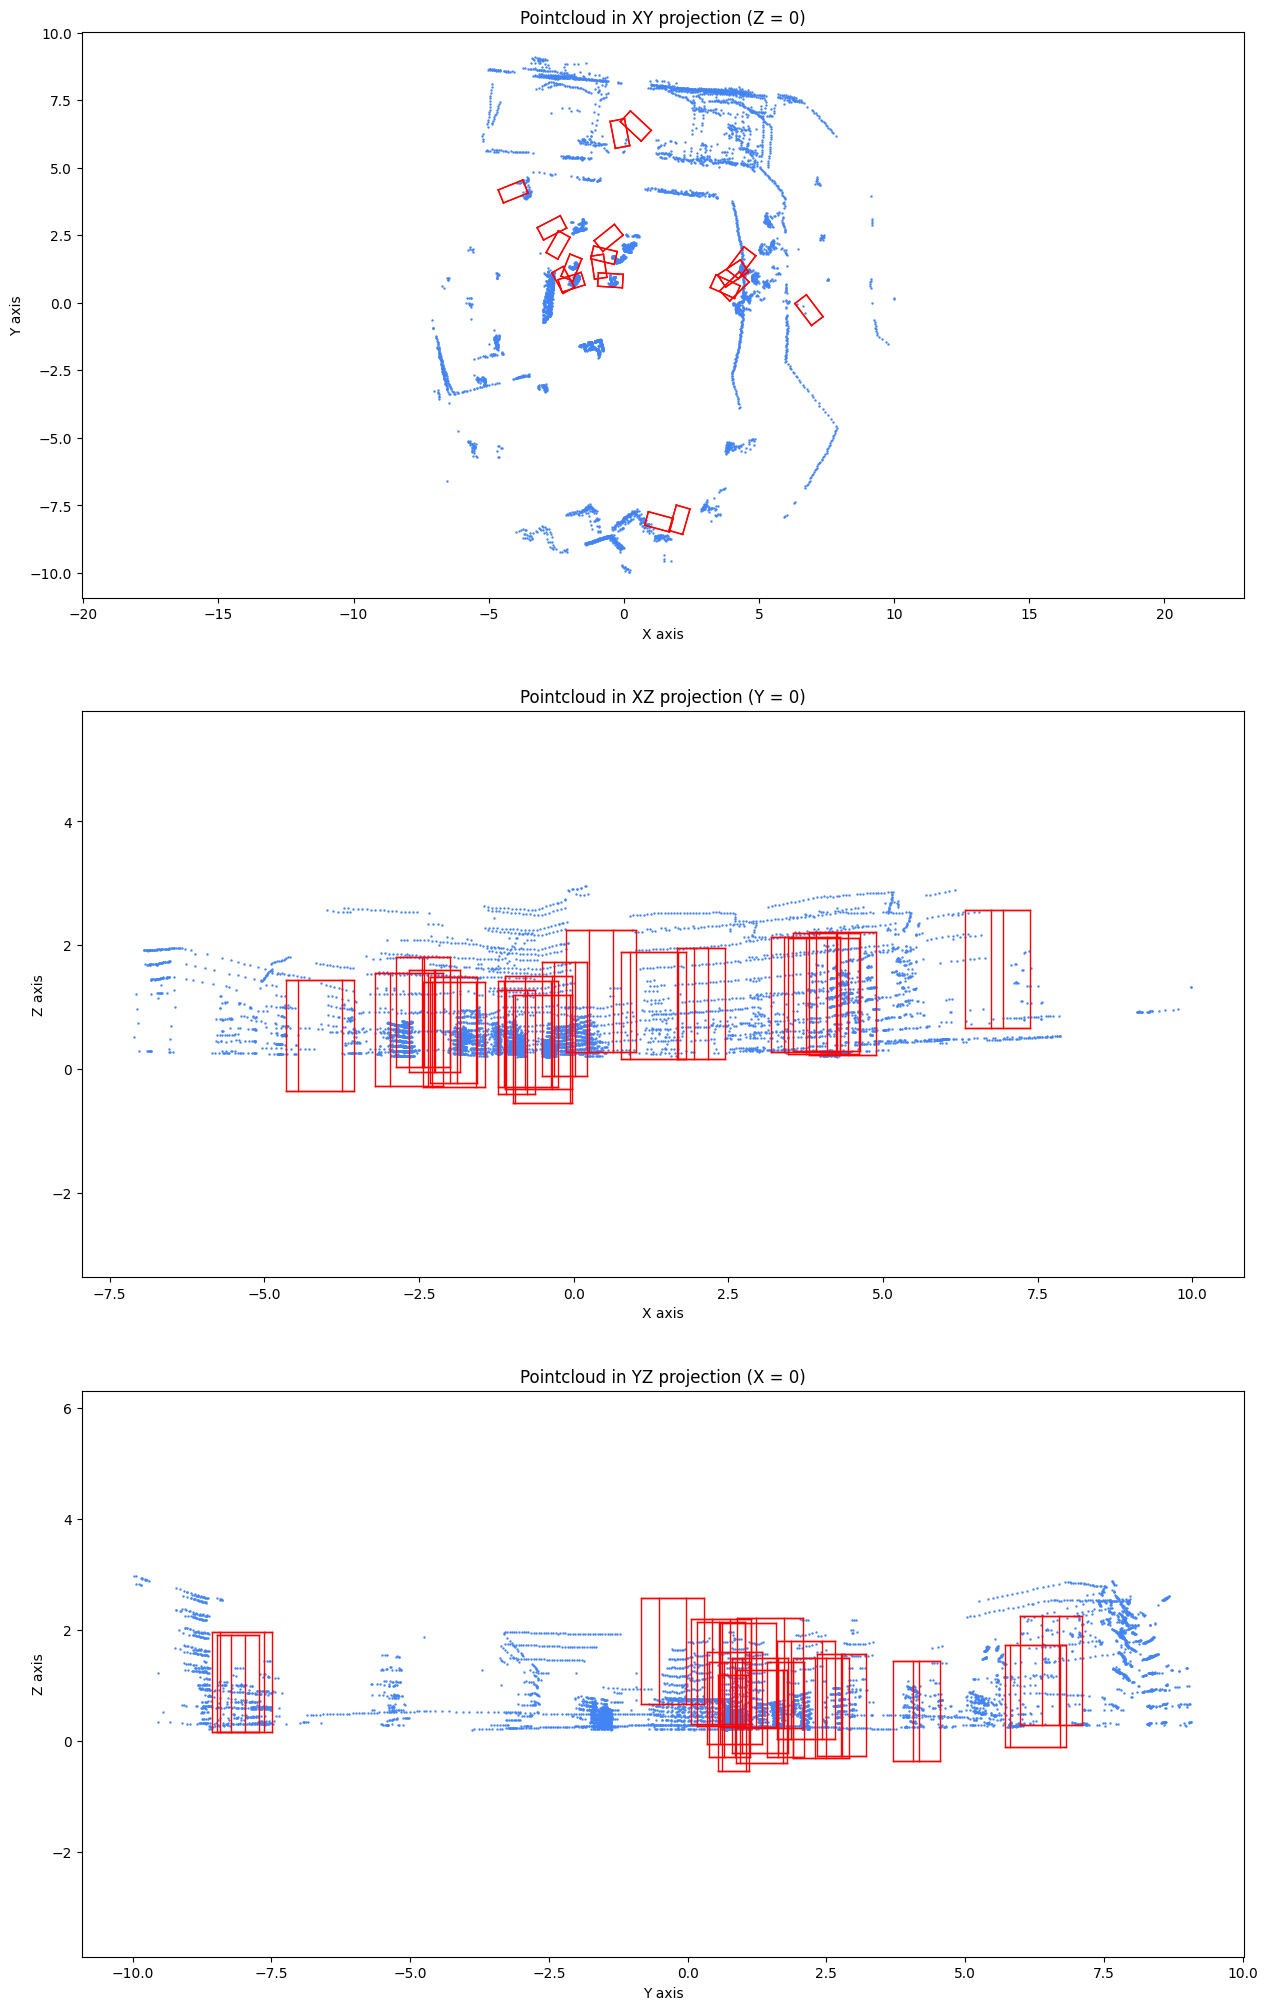

In [17]:
fig3d, fig_proj, ax3d, ax_proj = display_frame_all(
    pc, axes_limits=default_axes_limits, bbox=trks,
)
# fig_proj.savefig('test_proj.png', bbox_inches='tight')
# fig3d.savefig('test_3d.png', bbox_inches='tight')
pdf_save_dir = Path("./pdf")
if not os.path.isdir(pdf_save_dir):
    os.makedirs(pdf_save_dir)
fig_proj.savefig('./pdf/test_proj.pdf', bbox_inches='tight',dpi=300)
fig3d.savefig('./pdf/test_3d.pdf', bbox_inches='tight',dpi=300)
plt.show()

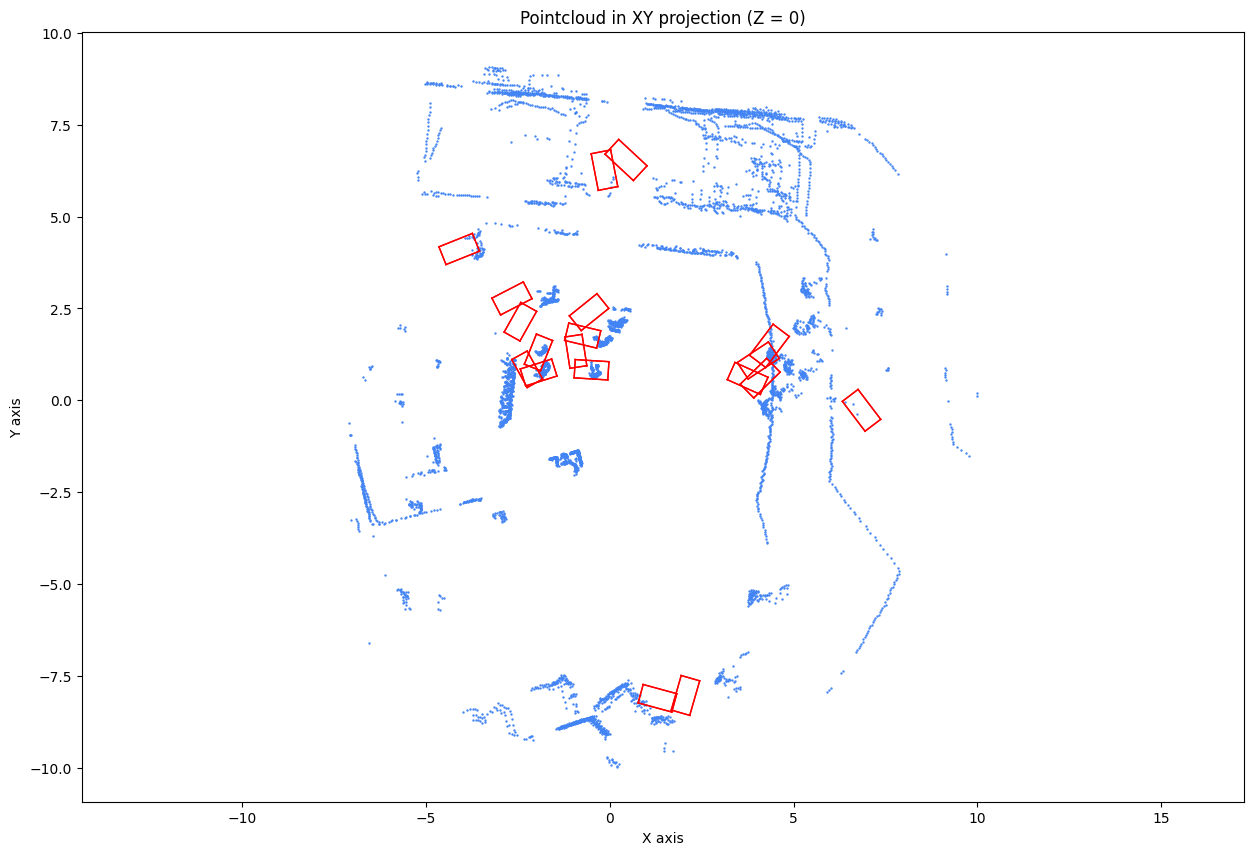

In [18]:
fig_xy = plt.figure(figsize=(15, 10))
fig_xy = display_frame(
    fig_xy, pc, axes_limits=get_limits(pc), bbox=trks,
)

plt.show()

### Single frame in 2D

In [19]:
from scipy.spatial.transform import Rotation as R

def get_yaw_from_quat(quat):
    scipy_rot = R.from_quat(quat)
    rot_zyx = scipy_rot.as_euler('zyx')
    return rot_zyx[0]

def get_quat_from_yaw(yaw):
    rot_euler = [yaw, 0, 0]
    scipy_rot = R.from_euler('zyx', rot_euler)
    return scipy_rot.as_quat()

def get_mat_from_yaw(yaw):
    rot_euler = [yaw, 0, 0]
    scipy_rot = R.from_euler('zyx', rot_euler)
    return scipy_rot.as_matrix()

def get_pc_tranform(pc, pos, quat):
    # pshape(pc)
    scipy_rot = R.from_quat(quat)
    rot_mat = scipy_rot.as_matrix() # 3x3
    # pshape(rot_mat)
    rot_pc = np.matmul(rot_mat, pc.T)  #  (3x3) (3xn)
    # pshape(rot_pc)
    return rot_pc.T + pos

In [20]:
print(get_quat_from_yaw(-np.pi))
mat = get_mat_from_yaw(np.pi/6)
print(mat)
res = np.matmul(mat, np.array([0,-1,0]).reshape(3,1))
res

[ 0.000000e+00  0.000000e+00 -1.000000e+00  6.123234e-17]
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]


array([[ 0.5      ],
       [-0.8660254],
       [ 0.       ]])

In [21]:
get_yaw_from_quat([0, 0, 0, 1.0])

pc = np.random.rand(6,3)
print(pc)
pos = [1,1,1]
quat = [0, 0, -1, 0]
pc = get_pc_tranform(pc, pos, quat)
print(pc)

[[0.35782772 0.07432214 0.65766387]
 [0.66540511 0.50903606 0.00445467]
 [0.0695547  0.03291642 0.70275387]
 [0.95623795 0.10997425 0.23897051]
 [0.91030375 0.83752112 0.54804572]
 [0.87539914 0.91871594 0.21550905]]
[[0.64217228 0.92567786 1.65766387]
 [0.33459489 0.49096394 1.00445467]
 [0.9304453  0.96708358 1.70275387]
 [0.04376205 0.89002575 1.23897051]
 [0.08969625 0.16247888 1.54804572]
 [0.12460086 0.08128406 1.21550905]]


- display every frame!

In [22]:
def display_frame_pose(
    fig,
    pose_stamped=None,
    fr_idx=fr_idx,
    pc=None,
    bbox=None,
    point_sz=0.5,
    points=0.8,
    title="",
    plotting=False,
    with_cloud=False,
    with_colorbar=True,
    with_id=False,
    filter_h=0.2,
    offset=7.5,
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    viz_axes = [0, 1]
    ax = fig.add_subplot(111)
    
    axes_limits = get_traj_limits(pose_stamped["position"], offset=offset)

    # robot position
    if pose_stamped is None:
        trans_array = np.random.rand(1, 3)
        quat_array = np.array([[0, 0, 0, 1]])
    else:
        trans_array = pose_stamped["position"][: fr_idx + 1]
        quat_array = pose_stamped["orientation"][: fr_idx + 1]
        ts = pose_stamped["timestamp"][: fr_idx + 1]
        ts = ts - np.min(ts)

    pose_viz_step = 10
    id_list = np.arange(0, trans_array.shape[0], pose_viz_step)
    ts_list = ts[id_list]

    new_trans_array = trans_array[id_list, :]
    new_quat_array = quat_array[id_list, :]
    traj_plot = ax.scatter(
        new_trans_array[:, 0],
        new_trans_array[:, 1],
        c=ts_list,
        cmap='YlOrRd', # 'Purples', 'PuBuGn'
        marker="o",
        linewidth=2,
        s=100,
        alpha=0.5,
        edgecolors='None'
    )
    
    # colorbar
    if with_colorbar:
        # https://stackoverflow.com/a/18195921/7961693
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        cbar = plt.colorbar(traj_plot, cax=cax)
        cbar.set_label('Time [s]')
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=200,
    )
    
    # arrow
    arrow_len = 1.0
    curr_yaw = get_yaw_from_quat(quat_array[-1, :])
    xy = (trans_array[-1, 0], trans_array[-1, 1])
    dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
    # https://stackoverflow.com/a/498103/7961693
    xytext = tuple(map(sum, zip(xy, dxy)))
    ax.annotate(
        "",
        xy=xy,
        xytext=xytext,
        arrowprops=dict(arrowstyle="<-", lw=2),
        color='purple',
    )

    # pointcloud filter
    pc = filter_pointcloud_distance(pc, filter_dist, verbose)
    pc = pc[pc[:,2]>=filter_h]
    # downsample
    points_step = int(1.0 / points)
    point_idx = range(0, pc.shape[0], points_step)
    pc = pc[point_idx, :]
    pc_trans = get_pc_tranform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
    
    if with_cloud:
        ax.scatter(
            pc_trans[:, viz_axes[0]], pc_trans[:, viz_axes[1]], s=point_sz, c=gs_blue
        )

    if len(viz_axes) > 2:
        ax.set_xlim3d(*axes_limits[viz_axes[0]])
        ax.set_ylim3d(*axes_limits[viz_axes[1]])
        ax.set_zlim3d(*axes_limits[viz_axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[viz_axes[2]]))
    else:
        ax.set_xlim(*axes_limits[viz_axes[0]])
        ax.set_ylim(*axes_limits[viz_axes[1]])

    # bbox
    if bbox is not None:
        # bbox: [x, y, z, dx, dy, dz, heading]
        # https://stackoverflow.com/a/23596637/7961693
        bbox = filter_detection_tracking_res(bbox, dist=filter_dist, verbose=verbose)
        ids = bbox[:, -1]
        bbox_trans = get_pc_tranform(
            bbox[:, :3], pos=trans_array[-1, :], quat=quat_array[-1, :]
        )
        ax.scatter(
            bbox_trans[:-1, 0],
            bbox_trans[:-1, 1],
            s=200,
            marker="o",
            c="None",
            edgecolors='r',
            linewidths=2,
        )
        if with_id:
            for idx, id in enumerate(ids):
                id = int(id)
                ax.text(
                    bbox_trans[idx, 0], 
                    bbox_trans[idx, 1], 
                    id,
                    fontsize=10,
                    fontweight='bold',
                    c='red',
                    ha='left',
                    va='bottom',
                )

    # It is not currently possible to manually set the aspect on 3D axes
    # ax.axis('equal')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[viz_axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[viz_axes[1]]))

    if plotting:
        plt.show()

    return fig

In [23]:
seq_idx, fr_idx = 0, 100

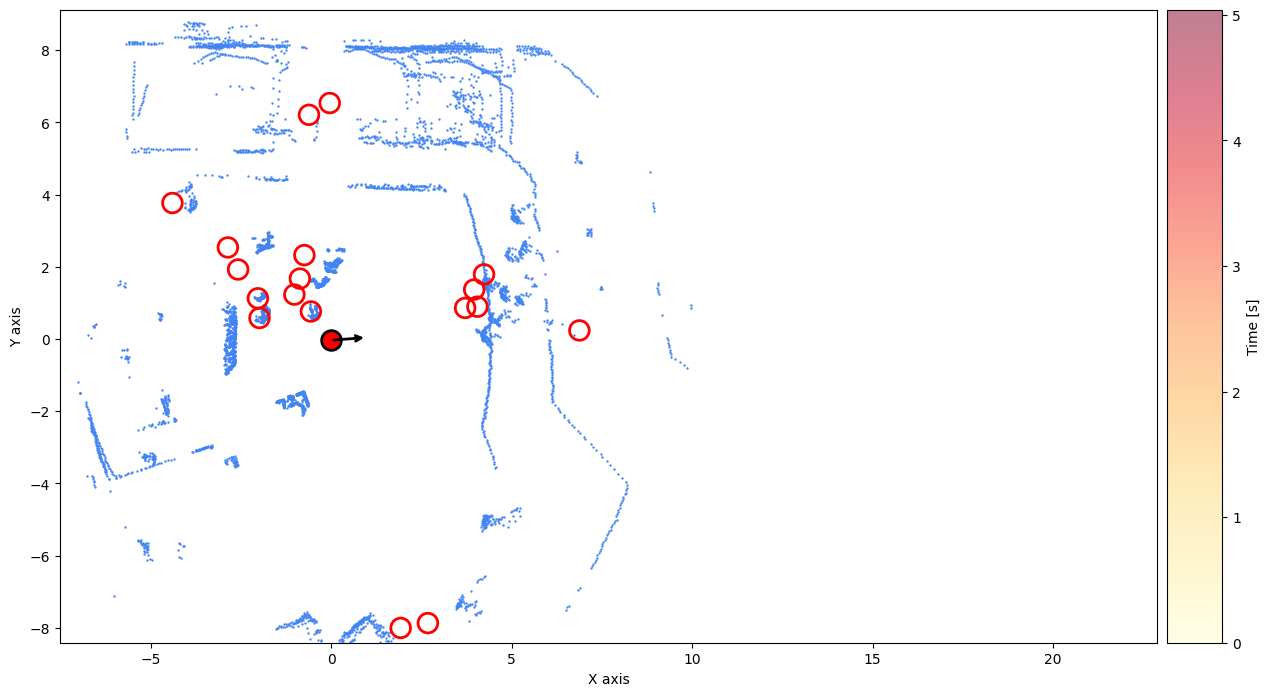

In [24]:
seq = cb_data.seqs[seq_idx]

lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

consider_pose = True
if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()
    
fig_xy = plt.figure(figsize=(15, 10))
fig_xy = display_frame_pose(
    fig_xy, 
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks,
    with_cloud=True,
    with_id=False,
)

plt.show()

In [25]:
seq_idx, fr_idx = 0, 500

In [26]:
lidar_pose_stamped["position"][fr_idx]

array([ 3.02704832, -0.4521466 ,  0.22750296])

In [27]:
a = R.from_quat(lidar_pose_stamped["orientation"][fr_idx])

In [28]:
line = np.linspace(0, 10, 10000)
three_line = np.tile(line, (3, 1))
three_line.T

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00010001e-03, 1.00010001e-03, 1.00010001e-03],
       [2.00020002e-03, 2.00020002e-03, 2.00020002e-03],
       ...,
       [9.99799980e+00, 9.99799980e+00, 9.99799980e+00],
       [9.99899990e+00, 9.99899990e+00, 9.99899990e+00],
       [1.00000000e+01, 1.00000000e+01, 1.00000000e+01]])

(-10.0, 10.0)

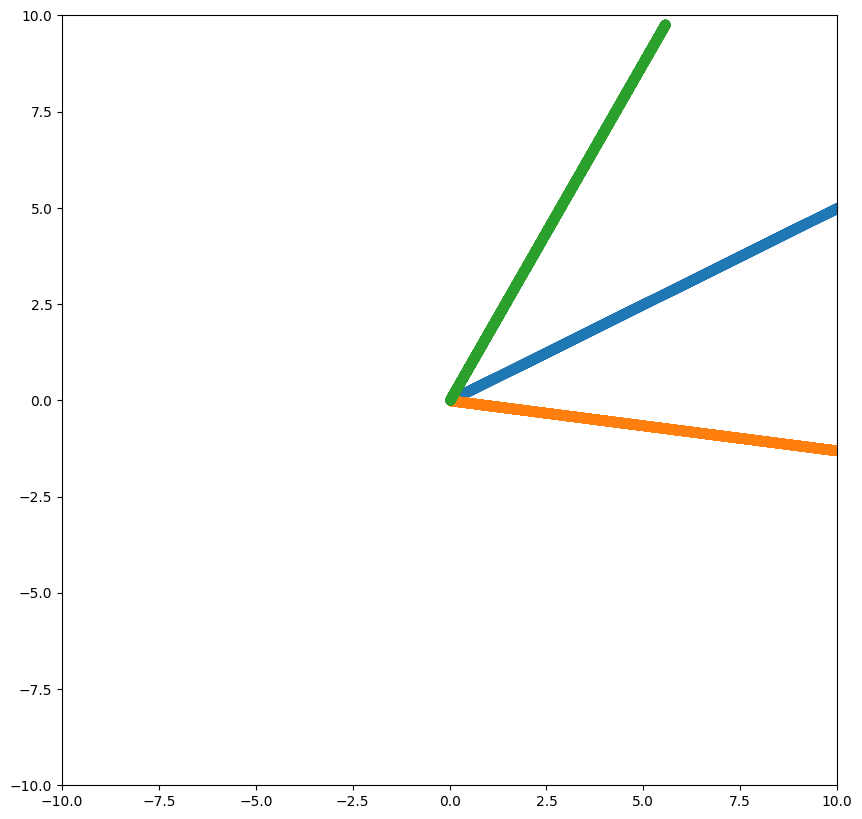

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
test_list = [[x/1000, x/2000, x/3000] for x in range(10000)]
test_line = np.array(test_list)
orient = lidar_pose_stamped["orientation"][fr_idx]
rot = R.from_quat(orient).as_matrix()
ax.scatter(test_line[:,0], test_line[:,1])
test_line_rot = np.matmul(test_line, rot)
ax.scatter(test_line_rot[:,0], test_line_rot[:,1])
test_line_rot2 = get_pc_tranform(test_line, 0, orient)
ax.scatter(test_line_rot2[:,0], test_line_rot2[:,1])
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

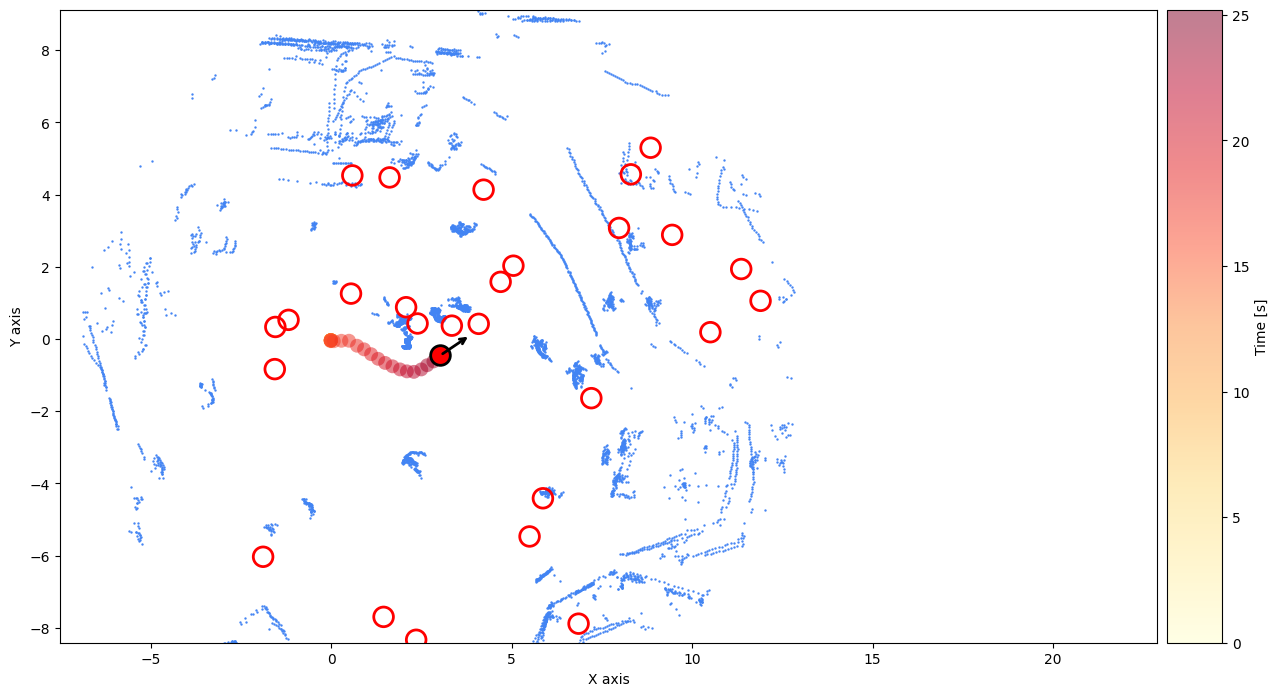

In [30]:
seq = cb_data.seqs[seq_idx]

lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

consider_pose = True
if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()
    
fig_xy = plt.figure(figsize=(15, 10))
fig_xy = display_frame_pose(
    fig_xy, 
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks,
    with_cloud=True,
    with_id=False,
)

plt.show()

In [31]:
# seq_idx, fr_idx = 0, 2372

# seq = cb_data.seqs[seq_idx]

# lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

# consider_pose = True
# if consider_pose:
#     tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
#     pose_stampe_path = os.path.join(
#         tf_qolo_dir, seq + "_tfqolo_sampled.npy"
#     )
#     lidar_pose_stamped = np.load(
#         pose_stampe_path, allow_pickle=True
#     ).item()
    
# fig_xy = plt.figure(figsize=(15, 10))
# fig_xy = display_frame_pose(
#     fig_xy, 
#     pose_stamped=lidar_pose_stamped,
#     fr_idx=fr_idx,
#     pc=lidar.T,  
#     bbox=trks,
#     with_cloud=True,
#     with_id=False,
# )

# fig_xy.savefig(
#     './pdf/qolo_traj_tracking_{}_frame{}.pdf'.format(seq, fr_idx), 
#     bbox_inches='tight',
#     dpi=300
# )

# plt.show()

### Multiple frames in 2D

#### aggregate multiple frames

In [32]:
def display_frame_pose_more(
    fig,
    pose_stamped=None,
    fr_idx=fr_idx,
    pc=None,
    bbox=None,
    point_sz=0.5,
    points=0.8,
    title="",
    plotting=False,
    with_cloud=False,
    with_colorbar=True,
    with_id=False,
    filter_h=0.2,
    offset=8,
    more_pc=None,
    more_bbox=None,
    more_frs=None,
    title_fontsz=20,
    label_fontsz=18,
    tag_fontsz=10,
    tick_fontsz=14,
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    viz_axes = [0, 1]
    ax = fig.add_subplot(111)
    
    axes_limits = get_traj_limits(pose_stamped["position"], offset=offset)

    # robot position
    if pose_stamped is None:
        trans_array = np.random.rand(1, 3)
        quat_array = np.array([[0, 0, 0, 1]])
    else:
        trans_array = pose_stamped["position"][: fr_idx + 1]
        quat_array = pose_stamped["orientation"][: fr_idx + 1]
        ts = pose_stamped["timestamp"][: fr_idx + 1]
        ts = ts - np.min(ts)

    pose_viz_step = 10
    id_list = np.arange(0, trans_array.shape[0], pose_viz_step)
    ts_list = ts[id_list]

    new_trans_array = trans_array[id_list, :]
    new_quat_array = quat_array[id_list, :]
    traj_plot = ax.scatter(
        new_trans_array[:, 0],
        new_trans_array[:, 1],
        c=ts_list,
        cmap='viridis', # 'Purples', 'PuBuGn' YlOrRd
        marker="o",
        linewidth=2,
        s=100,
        alpha=0.5,
        edgecolors='None'
    )
    
    # colorbar
    if with_colorbar:
        # https://stackoverflow.com/a/18195921/7961693
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        cbar = plt.colorbar(traj_plot, cax=cax)
        cbar.set_label('Time [s]', fontsize=label_fontsz)
        cbar.ax.tick_params(labelsize=tick_fontsz)
        
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=200,
    )
    
    # arrow
    arrow_len = 1.5
    curr_yaw = get_yaw_from_quat(quat_array[-1, :])
    xy = (trans_array[-1, 0], trans_array[-1, 1])
    dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
    # https://stackoverflow.com/a/498103/7961693
    xytext = tuple(map(sum, zip(xy, dxy)))
    ax.annotate(
        "",
        xy=xy,
        xytext=xytext,
        arrowprops=dict(arrowstyle="<-", lw=2),
        color='purple',
    )

    # pointcloud filter
    pc = filter_pointcloud_distance(pc, filter_dist, verbose)
    pc = pc[pc[:,2]>=filter_h]
    # downsample
    points_step = int(1.0 / points)
    point_idx = range(0, pc.shape[0], points_step)
    pc = pc[point_idx, :]
    pc_trans = get_pc_tranform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
    
    if with_cloud:
        ax.scatter(
            pc_trans[:, viz_axes[0]], pc_trans[:, viz_axes[1]], s=point_sz, c=gs_blue
        )
        
    # bbox
    if bbox is not None:
        # bbox: [x, y, z, dx, dy, dz, heading]
        # https://stackoverflow.com/a/23596637/7961693
        bbox = filter_detection_tracking_res(bbox, dist=filter_dist, verbose=verbose)
        ids = bbox[:, -1]
        bbox_trans = get_pc_tranform(
            bbox[:, :3], pos=trans_array[-1, :], quat=quat_array[-1, :]
        )
        ax.scatter(
            bbox_trans[:-1, 0],
            bbox_trans[:-1, 1],
            s=200,
            marker="o",
            c="None",
            edgecolors='r',
            linewidths=2,
        )
        if with_id:
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            for idx, ped_id in enumerate(ids):
                ped_id = int(ped_id)
                ax.text(
                    bbox_trans[idx, 0]+0.3, 
                    bbox_trans[idx, 1]+0.3, 
                    ped_id,
                    fontsize=tag_fontsz,
                    c='red',
                    ha='left',
                    va='bottom',
                    bbox=props,
                )
    
    if more_frs is not None:
        
        # derived from https://stackoverflow.com/a/49091378
        #import colormap to get color from cmap
        from matplotlib import cm

        #normalize item number values to colormap
        norm = mpl.colors.Normalize(vmin=0, vmax=1000)     
        
        for idx, (new_pc, fr) in enumerate(zip(more_pc, more_frs)):
            #colormap possible values = viridis, jet, spectral
            rgba_color = cm.viridis(norm(1000*fr/2500),bytes=True)

            color = np.array(rgba_color[:3])/256
            
            new_pc = filter_pointcloud_distance(new_pc, filter_dist, verbose)
            new_pc = new_pc[new_pc[:,2]>=filter_h]
            # downsample
            points_step = int(1.0 / points)
            point_idx = range(0, new_pc.shape[0], points_step)
            new_pc = new_pc[point_idx, :]

            pos = pose_stamped["position"][fr, :]
            quat = pose_stamped["orientation"][fr, :]


            # new arrows
            arrow_len = 1.5
            curr_yaw = get_yaw_from_quat(quat)
            xy = (pos[0], pos[1])
            dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
            # https://stackoverflow.com/a/498103/7961693
            xytext = tuple(map(sum, zip(xy, dxy)))
            ax.annotate(
                "",
                xy=xy,
                xytext=xytext,
                arrowprops=dict(arrowstyle="<-", lw=2),
                color=color,
            )
            
            # new pcs
            new_pc_trans = get_pc_tranform(new_pc, pos=pos, quat=quat)

            if with_cloud:
                ax.scatter(
                    new_pc_trans[:, viz_axes[0]], 
                    new_pc_trans[:, viz_axes[1]], 
                    s=point_sz, 
                    c=[color]*new_pc_trans.shape[0],
                )
            
            # new bbox
            bbox = more_bbox[idx]
            bbox = filter_detection_tracking_res(bbox, dist=filter_dist, verbose=verbose)
            ids = bbox[:, -1]
            bbox_trans = get_pc_tranform(
                bbox[:, :3], pos=pos, quat=quat
            )
            ax.scatter(
                bbox_trans[:-1, 0],
                bbox_trans[:-1, 1],
                s=200,
                marker="o",
                c="None",
                edgecolors=color,
                linewidths=2,
            )
            if with_id:
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                for idx, ped_id in enumerate(ids):
                    ped_id = int(ped_id)
                    ax.text(
                        bbox_trans[idx, 0]+0.3, 
                        bbox_trans[idx, 1]+0.3, 
                        ped_id,
                        fontsize=tag_fontsz,
                        c='red',
                        ha='left',
                        va='bottom',
                        bbox=props,
                    )

    if len(viz_axes) > 2:
        ax.set_xlim3d(*axes_limits[viz_axes[0]])
        ax.set_ylim3d(*axes_limits[viz_axes[1]])
        ax.set_zlim3d(*axes_limits[viz_axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[viz_axes[2]]))
    else:
        ax.set_xlim(*axes_limits[viz_axes[0]])
        ax.set_ylim(*axes_limits[viz_axes[1]])

    # It is not currently possible to manually set the aspect on 3D axes
    # ax.axis('equal')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=title_fontsz)
    # ax.set_xlabel('{} axis'.format(axes_str[viz_axes[0]]), fontsize=label_fontsz)
    # ax.set_ylabel('{} axis'.format(axes_str[viz_axes[1]]), fontsize=label_fontsz)
    ax.set_xlabel('{} [$m$]'.format(axes_str[viz_axes[0]]), fontsize=label_fontsz)
    ax.set_ylabel('{} [$m$]'.format(axes_str[viz_axes[1]]), fontsize=label_fontsz)
    ax.tick_params(axis='x', labelsize=tick_fontsz)
    ax.tick_params(axis='y', labelsize=tick_fontsz)

    if plotting:
        plt.show()

    return fig

##### Example: Frame 100, 1500, 2372

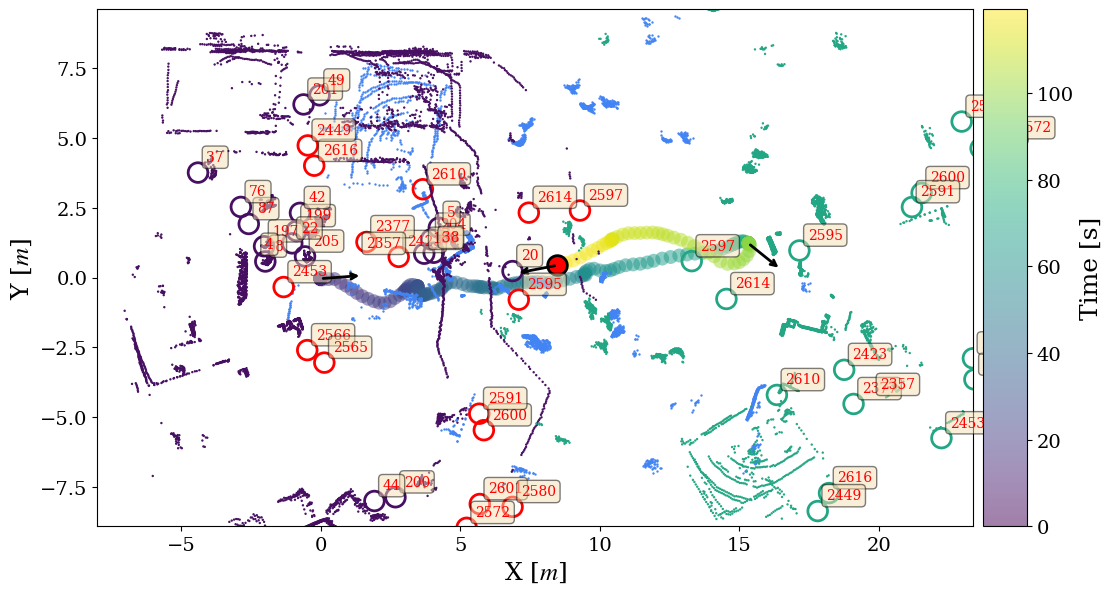

In [33]:
mpl.rcParams['font.family'] = ['serif']
# mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

seq_idx, fr_idx = 0, 2372

seq = cb_data.seqs[seq_idx]

lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

# viz more pointcloud
more_pc, more_bbox, more_frs = [], [], []
more_frs = [100, 1500]
for fr in more_frs:
    lidar, _, _, trks = cb_data[seq_idx, fr]
    more_pc.append(lidar.T)
    more_bbox.append(trks)

consider_pose = True
if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()
    
fig_xy = plt.figure(figsize=(12, 10))
fig_xy = display_frame_pose_more(
    fig_xy, 
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks,
    with_cloud=True,
    with_id=True,
    more_pc=more_pc,
    more_bbox=more_bbox,
    more_frs=more_frs,
)

fig_xy.savefig(
    './pdf/multi_frame_aggregate_{}.pdf'.format(seq), 
    bbox_inches='tight',
    dpi=300,
)

plt.show()

In [34]:
plt.close()

##### Example: Frame 1500

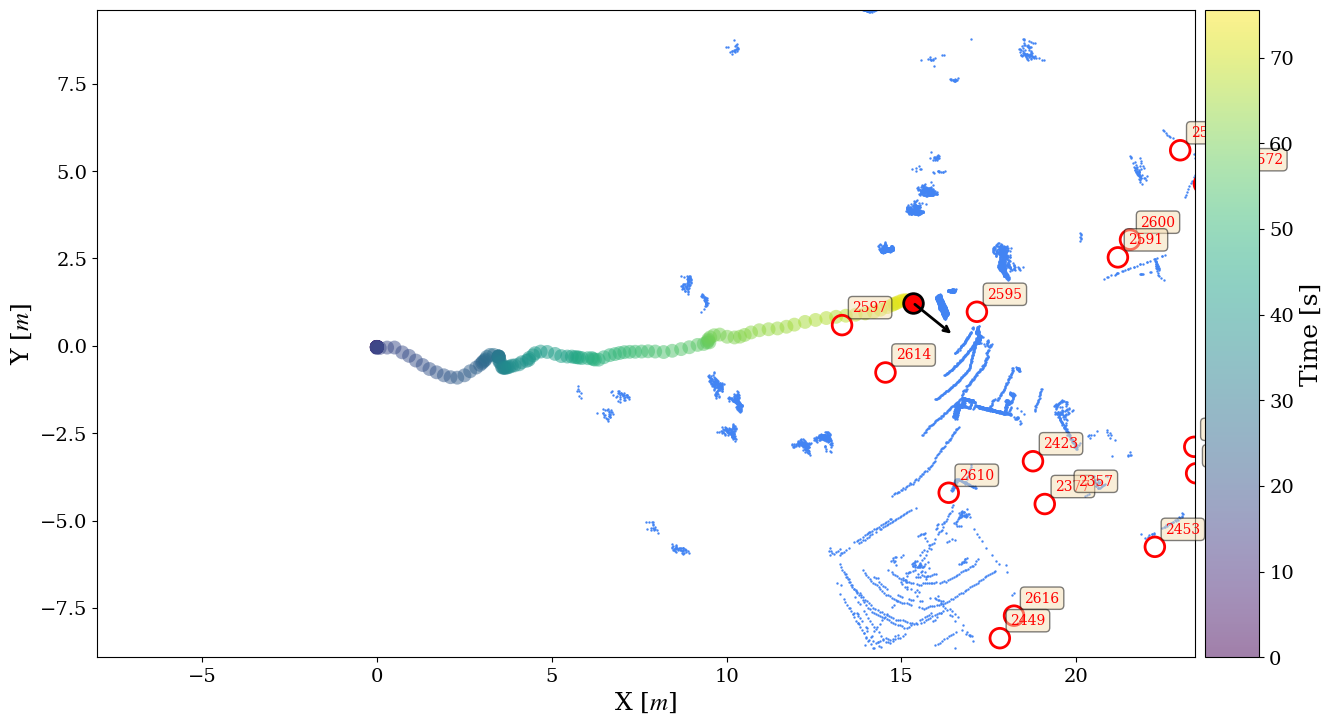

In [35]:
seq_idx, fr_idx = 0, 1500

seq = cb_data.seqs[seq_idx]

lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

# # viz more pointcloud
# more_pc, more_bbox, more_frs = [], [], []
# more_frs = [100, 1500]
# for fr in more_frs:
#     lidar, _, _, trks = cb_data[seq_idx, fr]
#     more_pc.append(lidar.T)
#     more_bbox.append(trks)

consider_pose = True
if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()
    
fig_xy = plt.figure(figsize=(15, 10))
fig_xy = display_frame_pose_more(
    fig_xy, 
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks,
    with_cloud=True,
    with_id=True,
    filter_h=-0.05,
#     more_pc=more_pc,
#     more_bbox=more_bbox,
#     more_frs=more_frs,
)

fig_xy.savefig(
    './pdf/single_frame_aggregate_{}_frame{}.pdf'.format(seq, fr_idx), 
    bbox_inches='tight',
    dpi=300,
)

plt.show()

In [36]:
plt.close()

-  multiple frames with looping

In [37]:
#SAVE IMAGES
# consider_pose = True
# seq_idx = 0
# seq = cb_data.seqs[seq_idx]

# if consider_pose:
#     tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
#     pose_stampe_path = os.path.join(
#         tf_qolo_dir, seq + "_tfqolo_sampled.npy"
#     )
#     lidar_pose_stamped = np.load(
#         pose_stampe_path, allow_pickle=True
#     ).item()

# step_viz = 10

# seq_len = cb_data.nr_frames(seq_idx)

# with tqdm.tqdm(total=(seq_len+1)//step_viz) as t:
#     for fr_idx in range(0, seq_len, step_viz):
        
#         lidar, _, _, trks = cb_data[seq_idx, fr_idx]

#         fig_xy = plt.figure(figsize=(15, 10))
        
#         fig_xy = display_frame_pose(
#             fig_xy, 
#             pose_stamped=lidar_pose_stamped,
#             fr_idx=fr_idx,
#             pc=lidar.T,  
#             bbox=trks,
#             with_cloud=True,
#             with_colorbar=False,
#             with_id=True,
#         )
#         save_dir = './archive/test/'
#         if not os.path.exists(save_dir):
#             os.makedirs(save_dir)
#         figpath = os.path.join(save_dir, "{0:04d}.png".format(fr_idx))
#         fig_xy.savefig(figpath, bbox_inches='tight',dpi=300)
#         plt.close()

#         t.update()

In [38]:
#MAKE VIDEO
# image_folder = save_dir
# video_name = 'multiple_frames.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# images.sort()
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MJPG'), 20, (width, height))

# for image in tqdm.tqdm(images):
#     video.write(cv2.imread(os.path.join(image_folder, image)))
    
# cv2.destroyAllWindows()
# video.release()

### Extract tracking results

In [39]:
# seq_idx, fr_idx = 0, 2300
consider_pose = True
seq_idx = 0
seq = cb_data.seqs[seq_idx]

if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()
    
trans_array = lidar_pose_stamped["position"]
quat_array = lidar_pose_stamped["orientation"]

peds_dict = dict()
seq_len = cb_data.nr_frames(seq_idx)

with tqdm.tqdm(total=seq_len) as t:
    for fr_idx in range(seq_len):
    # for fr_idx in range(50):

        # print("# Frame {}".format(fr_idx))
        _, _, _, trks = cb_data[seq_idx, fr_idx]

        # bbox: [x, y, z, dx, dy, dz, heading]
        # https://stackoverflow.com/a/23596637/7961693
        # bbox = filter_detection_tracking_res(trks, dist=filter_dist, verbose=verbose)
        bbox = trks
        ids = bbox[:, -1]
        
        # origin id in descending order
        sort_idx = np.argsort(ids)
        ids = ids[sort_idx]
        bbox_trans = bbox[sort_idx]
        
        # bbox_trans = get_pc_tranform(
        #     bbox[:, :3], pos=trans_array[fr_idx, :], quat=quat_array[fr_idx, :]
        # )
        # sing a library such as Pickle or do it yourself using Json strings.
        for idx, id in enumerate(ids):
            # if id==441:
            #     print("Track ID = " + str(id) + ", FRAME IDX = " + str(fr_idx) + ", ABS X POS = " + str(bbox_trans[idx, 0]))
            if id not in peds_dict.keys():
                # print("New pedestrian {} detected".format(id))
                id = int(id)
                ped_dict = {
                    'start_idx': fr_idx,
                    'fr_idx_list': [fr_idx],
                    'rel_pose_list': [(bbox[idx, :3]).tolist()],
                    'abs_pose_list': [(bbox_trans[idx, :3]).tolist()],
                }
                ped_dict.update({'length': len(ped_dict['fr_idx_list'])})
                ped_dict.update({'end_idx': ped_dict['fr_idx_list'][-1]})
            elif id in peds_dict.keys():
                # print("Update pedestrian {} detected".format(id))
                ped_dict = peds_dict[id]
                # print(ped_dict['rel_pose_list'])
                ped_dict['fr_idx_list'].append(fr_idx)
                ped_dict['rel_pose_list'].append((bbox[idx, :3]).tolist())
                ped_dict['abs_pose_list'].append((bbox_trans[idx, :3]).tolist())
                ped_dict['length'] += 1
                ped_dict['end_idx'] = fr_idx
            # print(ped_dict['length'], ped_dict['end_idx'])

            peds_dict.update({id: ped_dict})
        t.update()

100%|██████████| 2373/2373 [00:13<00:00, 173.58it/s]


- save as pkl and load pkl as dict

In [40]:
import pickle

save_dir = './archive/test/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# save
filehandler = open("./archive/test_traj.pkl","wb")
pickle.dump(peds_dict,filehandler)
filehandler.close()

# load
file = open("./archive/test_traj.pkl",'rb')
peds_dict = pickle.load(file)
file.close()

for idx, ped in zip(peds_dict.keys(), peds_dict.values()):
    if idx >= 5:
        break
    else:
        print(idx, type(ped))

1 <class 'dict'>
2 <class 'dict'>
3 <class 'dict'>
4 <class 'dict'>


- save as json and load json as dict

In [41]:
# # https://stackoverflow.com/a/21560696/7961693
# # https://pythonguides.com/convert-dictionary-to-json-python/
# import json

# # save
# with open("./archive/test_traj.json","w") as json_file:
#     json.dump(peds_dict, json_file, indent=2)

# # load
# # https://stackoverflow.com/a/54113201/13954301
# f = open("./archive/test_traj.json")
# peds_dict = json.load(
#     f,
#     object_hook=lambda d: {
#         int(k) if k.lstrip('-').isdigit() else k: v for k, v in d.items()
#     },
# )
# for idx, ped_id in enumerate(peds_dict):
#     if idx >= 5:
#         break
#     else:
#         print(ped_id, type(ped_id))

- tracklet analysis

In [42]:
# https://stackoverflow.com/a/33915728/7961693
# max(int(d['length']) for d in peds_dict.values())
max_len = max([int(ped['length']) for ped in peds_dict.values()])
id_max_len = [id for id in peds_dict.keys() if peds_dict[id]['length']==max_len]
print(id_max_len) # 1819

peds_dict[id_max_len[0]]['length']

[1031]


540

In [43]:
def get_len_less(peds_dict, target_len=100):
    idx_less = [ped_id for ped_id in peds_dict.keys() if peds_dict[ped_id]['length']<=target_len]
    idx_more = [ped_id for ped_id in peds_dict.keys() if peds_dict[ped_id]['length']>target_len]
    # print("Tracklet less than {}: {}".format(target_len, len(idx_less)))
    return idx_less, idx_more

In [44]:
get_len_less(peds_dict, target_len=10)
get_len_less(peds_dict, target_len=100)
_, id_more200 = get_len_less(peds_dict, target_len=200)
print(id_more200)
print("All tracklet number:", len(peds_dict.keys()))

[8, 197, 205, 259, 282, 285, 306, 317, 429, 430, 476, 526, 1018, 1031, 1038, 1050, 1063, 1105, 1112, 1113, 1131, 1200, 1750, 1601, 1466, 1784, 1795, 1805, 1841, 1894, 1929, 2449, 2423, 2582, 2357, 2425, 2614, 2642, 2694, 2716, 2734, 2784, 3147, 3210, 3226]
All tracklet number: 1164


In [45]:
peds_dict[id_more200[0]]['abs_pose_list'][0][0]

-1.9482741355895996

In [46]:
def get_curr_top(peds_dict, fr_idx, top=10):
    # https://stackoverflow.com/a/3420156/7961693
    dict_curr = {
        id: peds_dict[id]
        for id in peds_dict.keys()
        if peds_dict[id]['start_idx'] <= fr_idx
    }

    dict_curr_finished = {
        id: dict_curr[id]
        for id in dict_curr.keys()
        if dict_curr[id]['end_idx'] <= fr_idx
    }
    dict_curr_unfinished = {
        id: dict_curr[id]
        for id in dict_curr.keys()
        if dict_curr[id]['end_idx'] > fr_idx
    }
    
    finished_lenlist = [
        [int(id), dict_curr_finished[id]['length']] 
        for id in dict_curr_finished.keys()
    ]
    unfinished_lenlist = [
        [int(id), fr_idx - dict_curr_unfinished[id]['start_idx'] + 1]
         for id in dict_curr_unfinished.keys()
    ]
    
    # https://stackoverflow.com/a/6910672/7961693
    curr_lenlist = np.array(finished_lenlist+unfinished_lenlist, dtype=int)
    sort_idx = np.argsort(curr_lenlist[:,1])
    curr_lenlist = curr_lenlist[sort_idx]
    longest_k = curr_lenlist[-top:,][::-1]
    return longest_k[:,0].tolist(), longest_k[:,1].tolist()

In [47]:
longest_idxs, longest_paths = get_curr_top(peds_dict, 1000, top=10)

In [48]:
longest_idxs

[197, 526, 205, 8, 430, 285, 1018, 1031, 282, 1038]

In [49]:
longest_paths

[494, 475, 396, 370, 297, 265, 261, 261, 260, 260]

### multiple frames with tracklets

In [65]:
def display_frame_pose_traj(
    fig,
    peds_dict=None,
    pose_stamped=None,
    fr_idx=fr_idx,
    pc=None,
    bbox=None,
    point_sz=0.5,
    points=0.5,
    ground_processor=None,
    title="",
    plotting=False,
    with_cloud=False,
    with_colorbar=True,
    with_id=False
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    viz_axes = [0, 1]
    ax = fig.add_subplot(111)
    
    axes_limits = get_traj_limits(pose_stamped["position"], offset=10.0)
    
    # load pose_stamped
    if pose_stamped is None:
        trans_array = np.random.rand(1, 3)
        quat_array = np.array([[0, 0, 0, 1]])
    else:
        trans_array = pose_stamped["position"][: fr_idx + 1]
        quat_array = pose_stamped["orientation"][: fr_idx + 1]
        ts = pose_stamped["timestamp"][: fr_idx + 1]
        ts = ts - np.min(ts)
    
    # plot pointcloud
    # pc = filter_pointcloud_distance(pc, filter_dist, verbose)
    # downsample points
    # points_step = int(1.0 / points)
    # point_idx = range(0, pc.shape[0], points_step)
    # pc = pc[point_idx, :]
    pc_trans = get_pc_tranform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
    if ground_processor:
        pc_trans = ground_processor(pc_trans)
    
    if with_cloud:
        ax.scatter(
            pc_trans[:, viz_axes[0]], pc_trans[:, viz_axes[1]], s=point_sz, c=gs_blue
        )

    if len(viz_axes) > 2:
        ax.set_xlim3d(*axes_limits[viz_axes[0]])
        ax.set_ylim3d(*axes_limits[viz_axes[1]])
        ax.set_zlim3d(*axes_limits[viz_axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[viz_axes[2]]))
    else:
        ax.set_xlim(*axes_limits[viz_axes[0]])
        ax.set_ylim(*axes_limits[viz_axes[1]])

    # plot robot position
    pose_viz_step = 10
    id_list = np.arange(0, trans_array.shape[0], pose_viz_step)
    ts_list = ts[id_list]


    new_trans_array = trans_array[id_list, :]
    new_quat_array = quat_array[id_list, :]
    
    traj_plot = ax.scatter(
        new_trans_array[:, 0],
        new_trans_array[:, 1],
        c=ts_list,
        cmap='viridis', # 'Purples', 'PuBuGn'
        marker="o",
        linewidth=2,
        s=100,
        alpha=0.5,
    )
    # colorbar
    if with_colorbar:
        # https://stackoverflow.com/a/18195921/7961693
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        cbar = plt.colorbar(traj_plot, cax=cax)
        cbar.set_label('Time [s]')
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=100,
    )
    
    # arrow
    arrow_len = 1.0
    curr_yaw = get_yaw_from_quat(quat_array[-1, :])
    xy = (trans_array[-1, 0], trans_array[-1, 1])
    dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
    # https://stackoverflow.com/a/498103/7961693
    xytext = tuple(map(sum, zip(xy, dxy)))
    ax.annotate(
        "",
        xy=xy,
        xytext=xytext,
        arrowprops=dict(arrowstyle="<-", lw=2),
        color='purple',
    )

    # plot bbox
    if bbox is not None:
        # bbox: [x, y, z, dx, dy, dz, heading]
        # bbox = filter_detection_tracking_res(bbox, dist=filter_dist, verbose=verbose)
        ids = bbox[:, -1]
        # bbox_trans = get_pc_tranform(
        #     bbox[:, :3], pos=trans_array[-1, :], quat=quat_array[-1, :]
        # )
        
        # get the current top_10 longest traj
        # selected_ped_ids = get_curr_top(peds_dict, fr_idx, top=10)
        _, selected_ped_ids = get_len_less(peds_dict, target_len=60)
        plot_points = 100
        for ped_id in selected_ped_ids:
            traj_start = peds_dict[ped_id]['start_idx']
            traj_end = peds_dict[ped_id]['end_idx']
            traj_length = peds_dict[ped_id]['length']
            if traj_length < plot_points:
                plot_points = traj_length
            if fr_idx < traj_start or fr_idx >= traj_end+plot_points:
                continue
            ped_idxs = peds_dict[ped_id]['fr_idx_list']
            ped_idxs = np.array(ped_idxs)
            ped_idxs = ped_idxs[ped_idxs <= fr_idx]   
            ped_traj = peds_dict[ped_id]['abs_pose_list']
            ped_traj = np.array(ped_traj)
            ped_traj = ped_traj[:len(ped_idxs),:]
            if len(ped_idxs) > plot_points:
                ped_traj = ped_traj[-plot_points:,:]
                ped_idxs = ped_idxs[-plot_points:]
            if fr_idx > traj_end:
                ped_traj = ped_traj[fr_idx-traj_end:,:]
                ped_idxs = ped_idxs[fr_idx-traj_end:]

            # also downsample pedestrian
            pose_viz_step = 1
            ped_id_list = np.arange(0, ped_traj.shape[0], pose_viz_step)
            ped_traj = ped_traj[ped_id_list,:]
            # timestamp_shift = traj_start
            # ped_id_list += timestamp_shift

            # if(ped_id == 545):
            #     print("PED_ID, PED_START, PED_TRAJ, PED_ID_LIST")
            #     print(ped_id, traj_start, ped_traj.shape, ped_id_list.shape) 
            
            ax.scatter(
                ped_traj[:, 0],
                ped_traj[:, 1],
                s=40,
                marker="o",
                c=ts[ped_idxs],
                edgecolors='None',
                linewidths=2,
                alpha=0.2,
            )
            
            if with_id:
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                ax.text(
                    ped_traj[-1, 0], 
                    ped_traj[-1, 1], 
                    ped_id,
                    fontsize=10,
                    c='red',
                    ha='left',
                    va='bottom',
                    bbox=props,
                    alpha=0.2,
                ).set_clip_on(True)

    # It is not currently possible to manually set the aspect on 3D axes
    # ax.axis('equal')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[viz_axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[viz_axes[1]]))

    if plotting:
        plt.show()

    return fig

- load traj

In [66]:
# load
import pickle
file = open("./archive/test_traj.pkl",'rb')
peds_dict = pickle.load(file)
file.close()

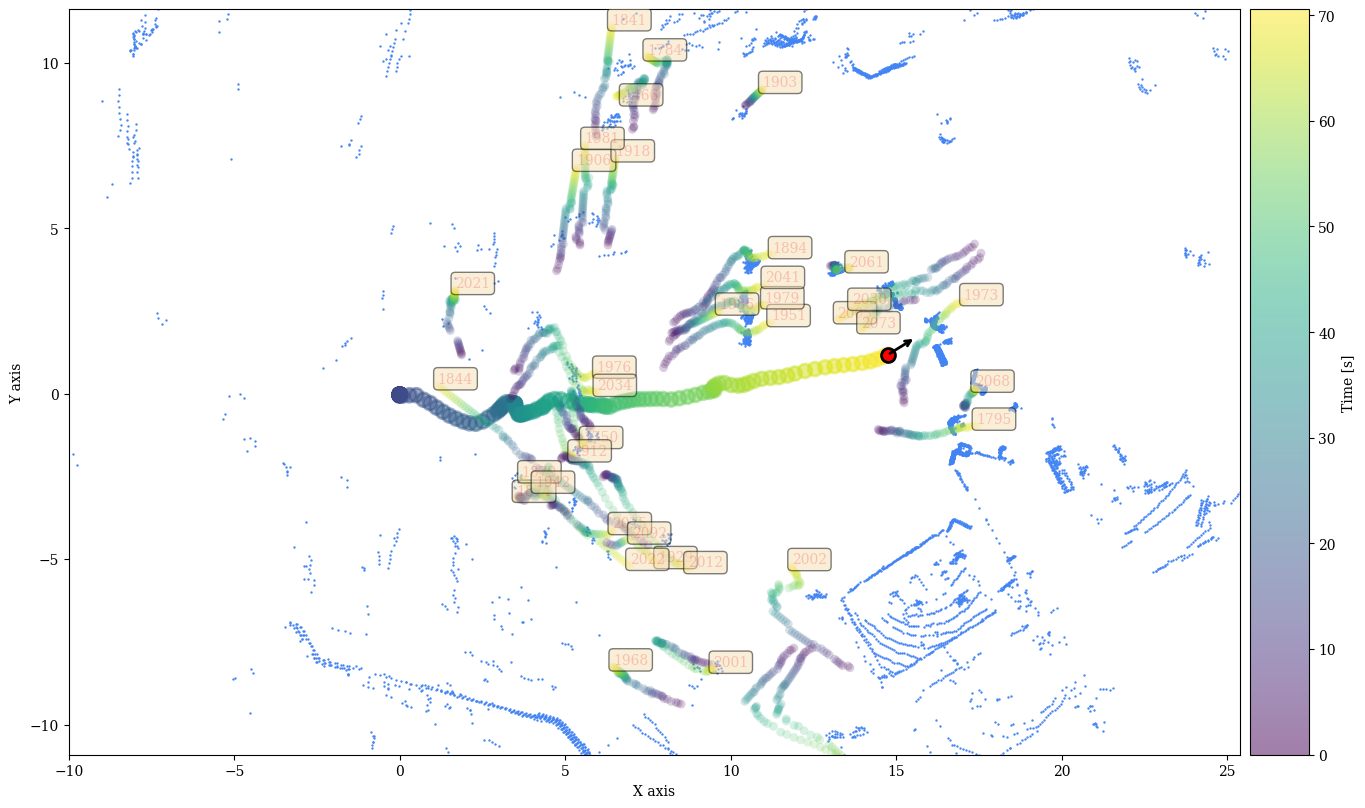

In [79]:
seq_idx, fr_idx = 0, 1400

seq = cb_data.seqs[seq_idx]

lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

consider_pose = True
if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()

ground_processor = Processor(n_segments=70, n_bins=80, line_search_angle=0.3, max_dist_to_line=0.15,
                sensor_height=0.4, max_start_height=3, long_threshold=8)

fig_xy = plt.figure(figsize=(16, 10))
fig_xy = display_frame_pose_traj(
    fig_xy, 
    peds_dict=peds_dict,
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks,
    ground_processor=ground_processor,
    with_cloud=True,
    with_id=True,
)

plt.show()

In [80]:
consider_pose = True
seq_idx = 0
seq = cb_data.seqs[seq_idx]

if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()

step_viz = 2



for fr_idx in tqdm.tqdm(range(0, cb_data.nr_frames(seq_idx), step_viz)):
    
    # ped_ids = get_curr_top(peds_dict, fr_idx, top=10)
    ground_processor = Processor(n_segments=70, n_bins=80, line_search_angle=0.3, max_dist_to_line=0.15,
                sensor_height=0.4, max_start_height=3, long_threshold=8)
    
    lidar, _, _, trks = cb_data[seq_idx, fr_idx]

    fig_xy = plt.figure(figsize=(16, 10))
    
    fig_xy = display_frame_pose_traj(
        fig_xy, 
        peds_dict=peds_dict,
        pose_stamped=lidar_pose_stamped,
        fr_idx=fr_idx,
        pc=lidar.T,  
        bbox=trks,
        ground_processor=ground_processor,
        with_cloud=True,
        with_colorbar=False,
        with_id=True,
    )
    save_dir = './archive/test/tracks'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    figpath = os.path.join(save_dir, "{0:04d}.png".format(fr_idx))
    fig_xy.savefig(figpath, bbox_inches='tight',dpi=150)
    plt.close()

100%|██████████| 1187/1187 [03:46<00:00,  5.24it/s]


In [54]:
# #MAKE VIDEO
# image_folder = save_dir
# video_name = 'ped_tracks_small.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# images.sort()
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (int(width/3), int(height/3)))

# for image in tqdm.tqdm(images):
#     video.write(cv2.imread(os.path.join(image_folder, image)))
    
# cv2.destroyAllWindows()
# video.release()

In [81]:
def display_frame_pose_traj_less(
    fig,
    peds_dict=None,
    pose_stamped=None,
    fr_idx=fr_idx,
    pc=None,
    bbox=None,
    point_sz=0.5,
    points=0.5,
    ground_processor=None,
    max_dist=1,
    title="",
    plotting=False,
    with_cloud=False,
    with_colorbar=True,
    with_id=False
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    viz_axes = [0, 1]
    ax = fig.add_subplot(111)
    
    axes_limits = get_traj_limits(pose_stamped["position"], offset=10.0)
    
    # load pose_stamped
    if pose_stamped is None:
        trans_array = np.random.rand(1, 3)
        quat_array = np.array([[0, 0, 0, 1]])
    else:
        trans_array = pose_stamped["position"][: fr_idx + 1]
        quat_array = pose_stamped["orientation"][: fr_idx + 1]
        ts = pose_stamped["timestamp"][: fr_idx + 1]
        ts = ts - np.min(ts)
    

    # plot robot position
    pose_viz_step = 10
    id_list = np.arange(0, trans_array.shape[0], pose_viz_step)
    ts_list = ts[id_list]


    new_trans_array = trans_array[id_list, :]
    new_quat_array = quat_array[id_list, :]
    
    traj_plot = ax.scatter(
        new_trans_array[:, 0],
        new_trans_array[:, 1],
        c=ts_list,
        cmap='viridis', # 'Purples', 'PuBuGn'
        marker="o",
        linewidth=2,
        s=100,
        alpha=0.5,
    )
    # colorbar
    if with_colorbar:
        # https://stackoverflow.com/a/18195921/7961693
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        cbar = plt.colorbar(traj_plot, cax=cax)
        cbar.set_label('Time [s]')
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=100,
    )
    
    # arrow
    arrow_len = 1.0
    curr_yaw = get_yaw_from_quat(quat_array[-1, :])
    xy = (trans_array[-1, 0], trans_array[-1, 1])
    dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
    # https://stackoverflow.com/a/498103/7961693
    xytext = tuple(map(sum, zip(xy, dxy)))
    ax.annotate(
        "",
        xy=xy,
        xytext=xytext,
        arrowprops=dict(arrowstyle="<-", lw=2),
        color='purple',
    )

    # plot bbox
    if bbox is not None:
        # bbox: [x, y, z, dx, dy, dz, heading]
        # bbox = filter_detection_tracking_res(bbox, dist=filter_dist, verbose=verbose)
        ids = bbox[:, -1]
        # bbox_trans = get_pc_tranform(
        #     bbox[:, :3], pos=trans_array[-1, :], quat=quat_array[-1, :]
        # )
        
        # get the current top_10 longest traj
        # selected_ped_ids = get_curr_top(peds_dict, fr_idx, top=10)
        _, selected_ped_ids = get_len_less(peds_dict, target_len=60)
        plot_points = 100
        ped_locs = []
        for ped_id in selected_ped_ids:
            traj_start = peds_dict[ped_id]['start_idx']
            traj_end = peds_dict[ped_id]['end_idx']
            traj_length = peds_dict[ped_id]['length']
            if traj_length < plot_points:
                plot_points = traj_length
            if fr_idx < traj_start or fr_idx >= traj_end+plot_points:
                continue
            ped_idxs = peds_dict[ped_id]['fr_idx_list']
            ped_idxs = np.array(ped_idxs)
            ped_idxs = ped_idxs[ped_idxs <= fr_idx]   
            
            ped_traj = peds_dict[ped_id]['abs_pose_list']
            ped_traj = np.array(ped_traj)
            ped_traj = ped_traj[:len(ped_idxs),:]
            if len(ped_idxs) > plot_points:
                ped_traj = ped_traj[-plot_points:,:]
                ped_idxs = ped_idxs[-plot_points:]
            if fr_idx > traj_end:
                ped_traj = ped_traj[fr_idx-traj_end:,:]
                ped_idxs = ped_idxs[fr_idx-traj_end:]

            # also downsample pedestrian
            pose_viz_step = 1
            ped_id_list = np.arange(0, ped_traj.shape[0], pose_viz_step)
            ped_traj = ped_traj[ped_id_list,:]
            
            ax.scatter(
                ped_traj[:, 0],
                ped_traj[:, 1],
                s=40,
                marker="o",
                c=ts[ped_idxs],
                edgecolors='None',
                linewidths=2,
                alpha=0.2,
            )

            ped_locs.append((ped_traj[-1,0], ped_traj[-1,1])) # Add last point for the pedestrian to list
            
            if with_id:
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                ax.text(
                    ped_traj[-1, 0], 
                    ped_traj[-1, 1], 
                    ped_id,
                    fontsize=10,
                    c='red',
                    ha='left',
                    va='bottom',
                    bbox=props,
                    alpha=0.1,
                ).set_clip_on(True)

    ped_locs = np.array(ped_locs)
        
    pc_trans = get_pc_tranform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])

    if ground_processor:
        pc_trans = ground_processor(pc_trans)
        
    pc_filtered_idxs = []
    for ped_loc in ped_locs:
        pc_ped_idxs = np.where(((pc_trans[:, 0] - ped_loc[0])**2 + (pc_trans[:, 1] - ped_loc[1])**2)**(1/2) <= max_dist)
        pc_filtered_idxs.append(pc_ped_idxs)
    pc_filtered_idxs = np.unique(np.concatenate(pc_filtered_idxs, axis=None))
    pc_trans = pc_trans[pc_filtered_idxs,:]
    
    # plot pointcloud
    # pc = filter_pointcloud_distance(pc, filter_dist, verbose)
    # downsample points
    # points_step = int(1.0 / points)
    # point_idx = range(0, pc.shape[0], points_step)
    # pc = pc[point_idx, :]
    
    if with_cloud:
        ax.scatter(
            pc_trans[:, viz_axes[0]], pc_trans[:, viz_axes[1]], s=point_sz, c=gs_blue
        )

    ax.set_xlim(*axes_limits[viz_axes[0]])
    ax.set_ylim(*axes_limits[viz_axes[1]])

    # It is not currently possible to manually set the aspect on 3D axes
    # ax.axis('equal')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[viz_axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[viz_axes[1]]))

    if plotting:
        plt.show()

    return fig

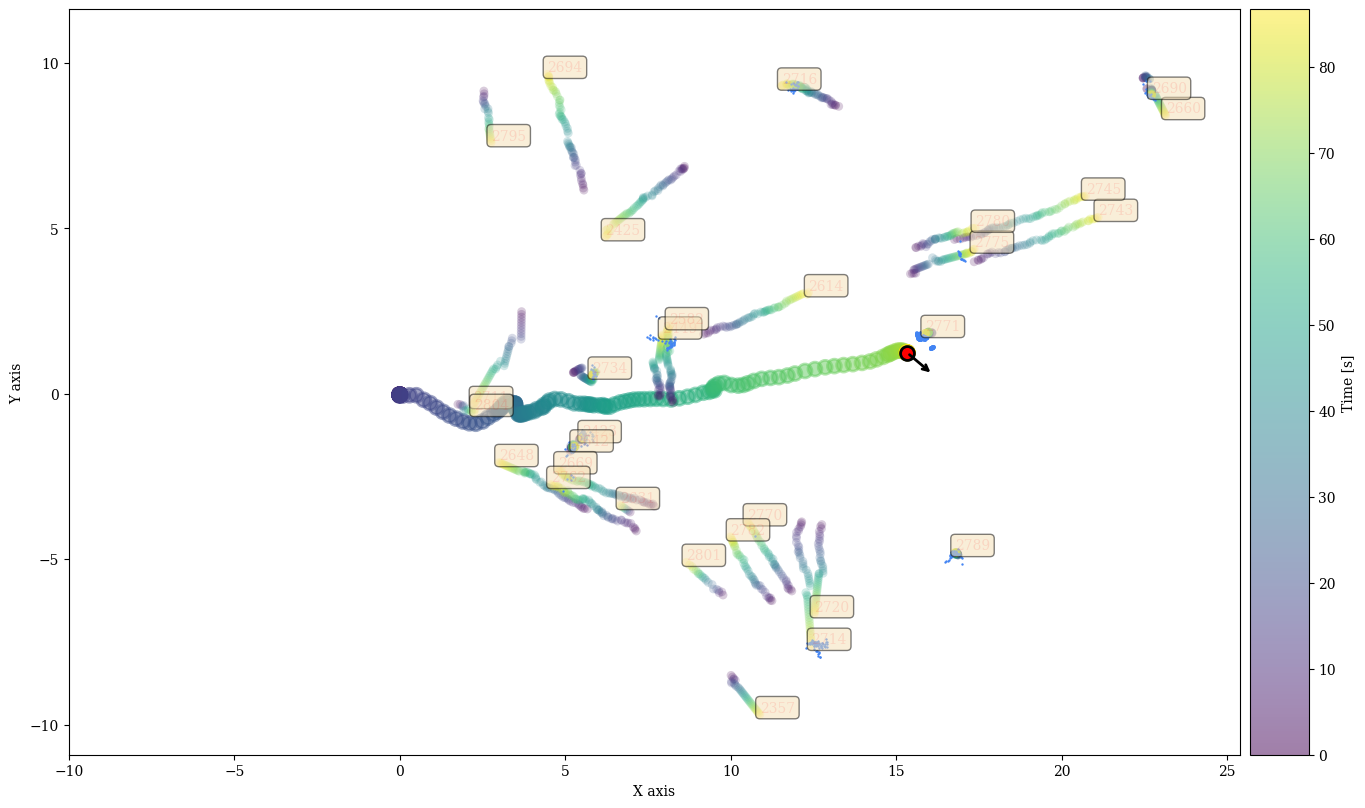

In [82]:
seq_idx, fr_idx = 0, 1720

seq = cb_data.seqs[seq_idx]

lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]

consider_pose = True
if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()

ground_processor = Processor(n_segments=70, n_bins=80, line_search_angle=0.3, max_dist_to_line=0.15,
                sensor_height=0.4, max_start_height=3, long_threshold=8)
    
fig_xy = plt.figure(figsize=(16, 10))
fig_xy = display_frame_pose_traj_less(
    fig_xy, 
    peds_dict=peds_dict,
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks,
    max_dist=0.5,
    ground_processor=ground_processor,
    with_cloud=True,
    with_id=True,
)

plt.show()

In [83]:
consider_pose = True
seq_idx = 0
seq = cb_data.seqs[seq_idx]

if consider_pose:
    tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
    pose_stampe_path = os.path.join(
        tf_qolo_dir, seq + "_tfqolo_sampled.npy"
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()

step_viz = 2


for fr_idx in tqdm.tqdm(range(0, cb_data.nr_frames(seq_idx), step_viz)):
    
    # ped_ids = get_curr_top(peds_dict, fr_idx, top=10)
    
    lidar, _, _, trks = cb_data[seq_idx, fr_idx]

    ground_processor = Processor(n_segments=70, n_bins=80, line_search_angle=0.3, max_dist_to_line=0.15,
                sensor_height=0.4, max_start_height=3, long_threshold=8)

    fig_xy = plt.figure(figsize=(16, 10))
    
    fig_xy = display_frame_pose_traj_less(
        fig_xy, 
        peds_dict=peds_dict,
        pose_stamped=lidar_pose_stamped,
        fr_idx=fr_idx,
        pc=lidar.T,  
        bbox=trks,
        max_dist=1,
        ground_processor=ground_processor,
        with_cloud=True,
        with_colorbar=False,
        with_id=True,
    )
    save_dir = './archive/test/tracks_filtered'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    figpath = os.path.join(save_dir, "{0:04d}.png".format(fr_idx))
    fig_xy.savefig(figpath, bbox_inches='tight',dpi=150)
    plt.close()

100%|██████████| 1187/1187 [03:49<00:00,  5.17it/s]


In [58]:
# #MAKE VIDEO
# image_folder = save_dir
# video_name = 'ped_tracks_orig_no_ground.mp4'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png") and (int(img[0:4]) % step_viz == 0)]
# images.sort()
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

# for image in tqdm.tqdm(images):
#     video.write(cv2.imread(os.path.join(image_folder, image)))
    
# cv2.destroyAllWindows()
# video.release()